# -*- coding: utf-8 -*-

In [1]:
from IPython.display import Audio, Image, IFrame
from IPython.display import display
from IPython.display import display_pdf

### Motivation
Cross-lingual tools are currently available for only a small fraction (< 200) of the several thousand languages spoken by people around the world (Besacier et al., 2014). This gap becomes critically apparent during disaster recovery scenarios, such as earthquake or flood relief, where international teams of aid workers may struggle to effectively communicate with the local populations (Munro, 2010).
### Challenge
Building such tools is prohibitive due to the training data required, which takes the form of: speech, transcribed speech, parallel text in English. 

| Type of training data | Difficulty in procuring |
|:-------|:-----------|
|    Speech    | easily available |
|    Transcriptions    | difficult: costly, time-intensive, impossible  for languages without orthography|
|    English translations    | moderately difficult: can be crowdsourced in a short amount of time|


(Note: To provide a complete speech-to-speech application, we would also need transcribed speech in English.)

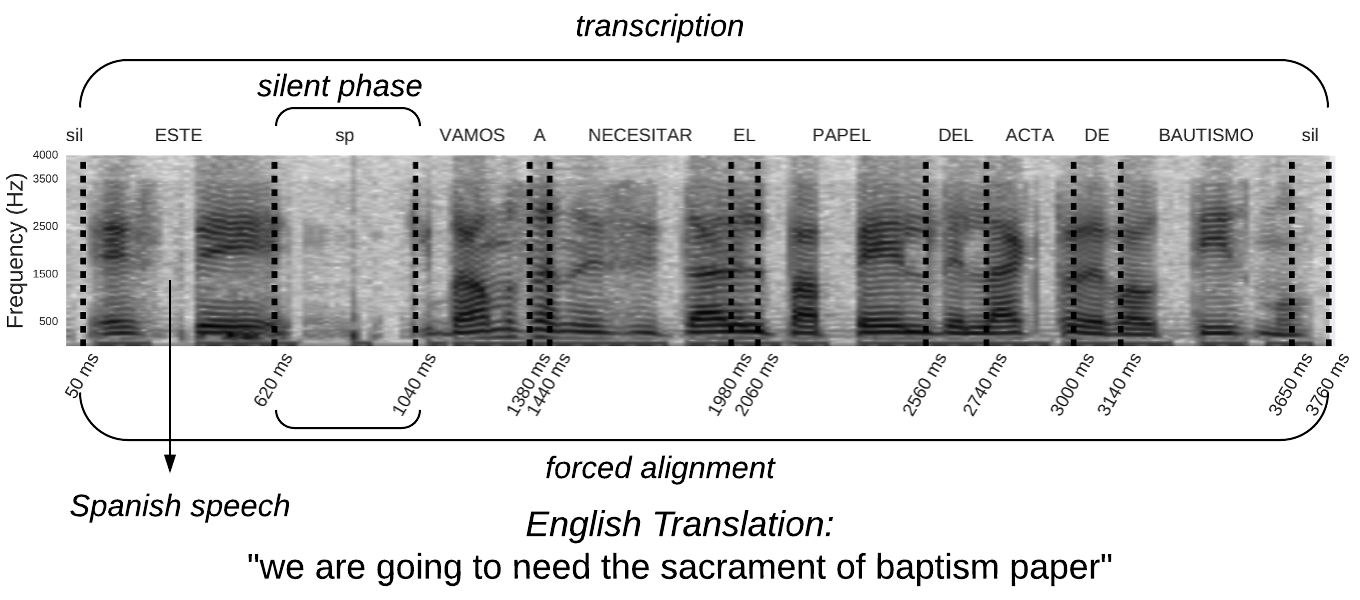

In [2]:
Image('output/speech_data.png')

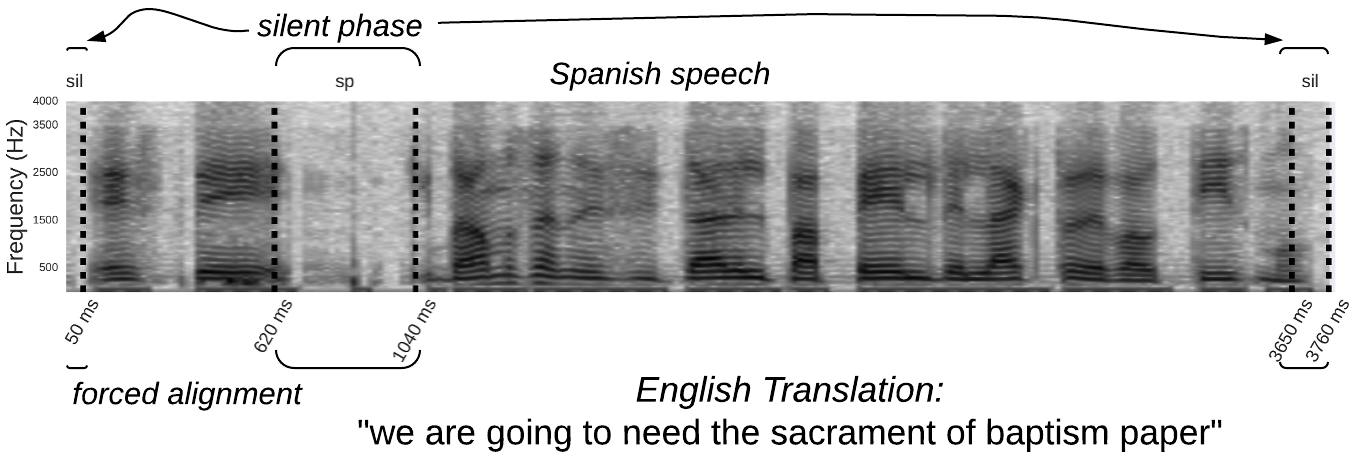

In [3]:
Image('output/training_data.png')

# Speech pattern discovery and evaluation on the CallHome dataset

Hundreds of spoken languages without any modern tools. Emergency situations like the Haiti earthquake  demonstrate the need for such tools. The crowdsourcing effort showed how we can collect data in the form of speech in one language, with text in English.
This would also be applicable for languages without a written form.

Key Idea:
We show that noisy labels, in the form of English translations, help improve the accuracy of UTD output.


## Unsupervised Term Discovery

### Dynamic Time Warping algorithm for detecting repeated speech segments

Speech data is recorded as a time series of signal amplitude (continuous) values. Segmental DTW was proposed by Alex Park et al. as an effective method of extracting patterns from speech data. The repeated terms can be word, sub-word or compound-word like units. In order to use speech data for downstream applications such as: Machine Translation, Query-by-Example, among others, these discovered terms provide a psuedo discrete tokenisation of the continuous data. In this work, we use the Zero Resource Toolkit made available by Aren et al. The toolkit allows us to perform UTD in relativly quick time.

Consider the following two speech inputs:

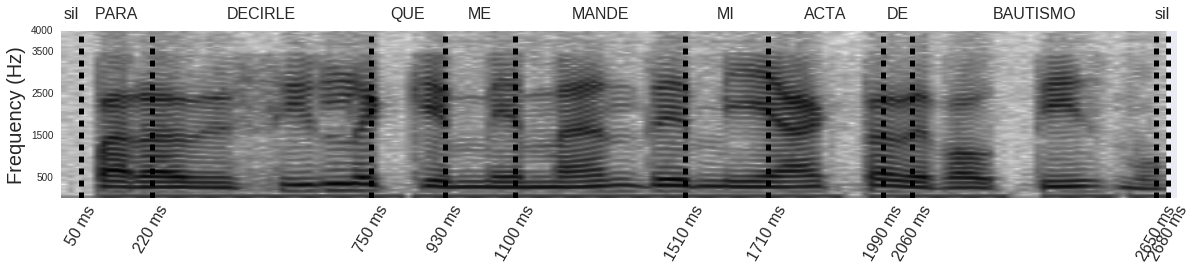

In [4]:
Image("output/bautismo_1761.png")

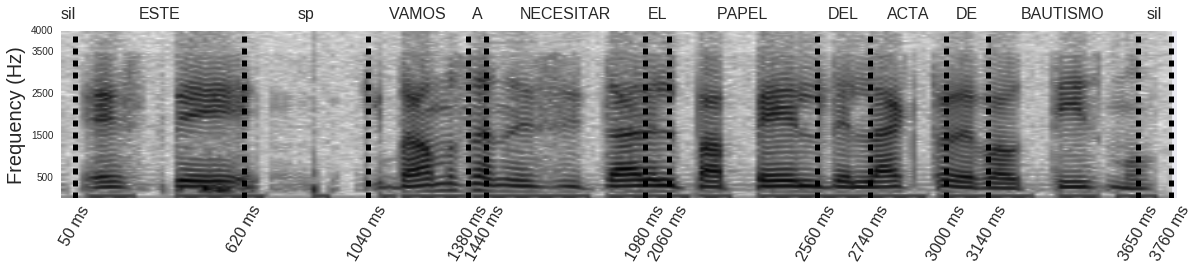

In [5]:
Image("output/bautismo_1762.png")

An acoustic dotplot computed over the MFCC representations of these utterances appears as follows

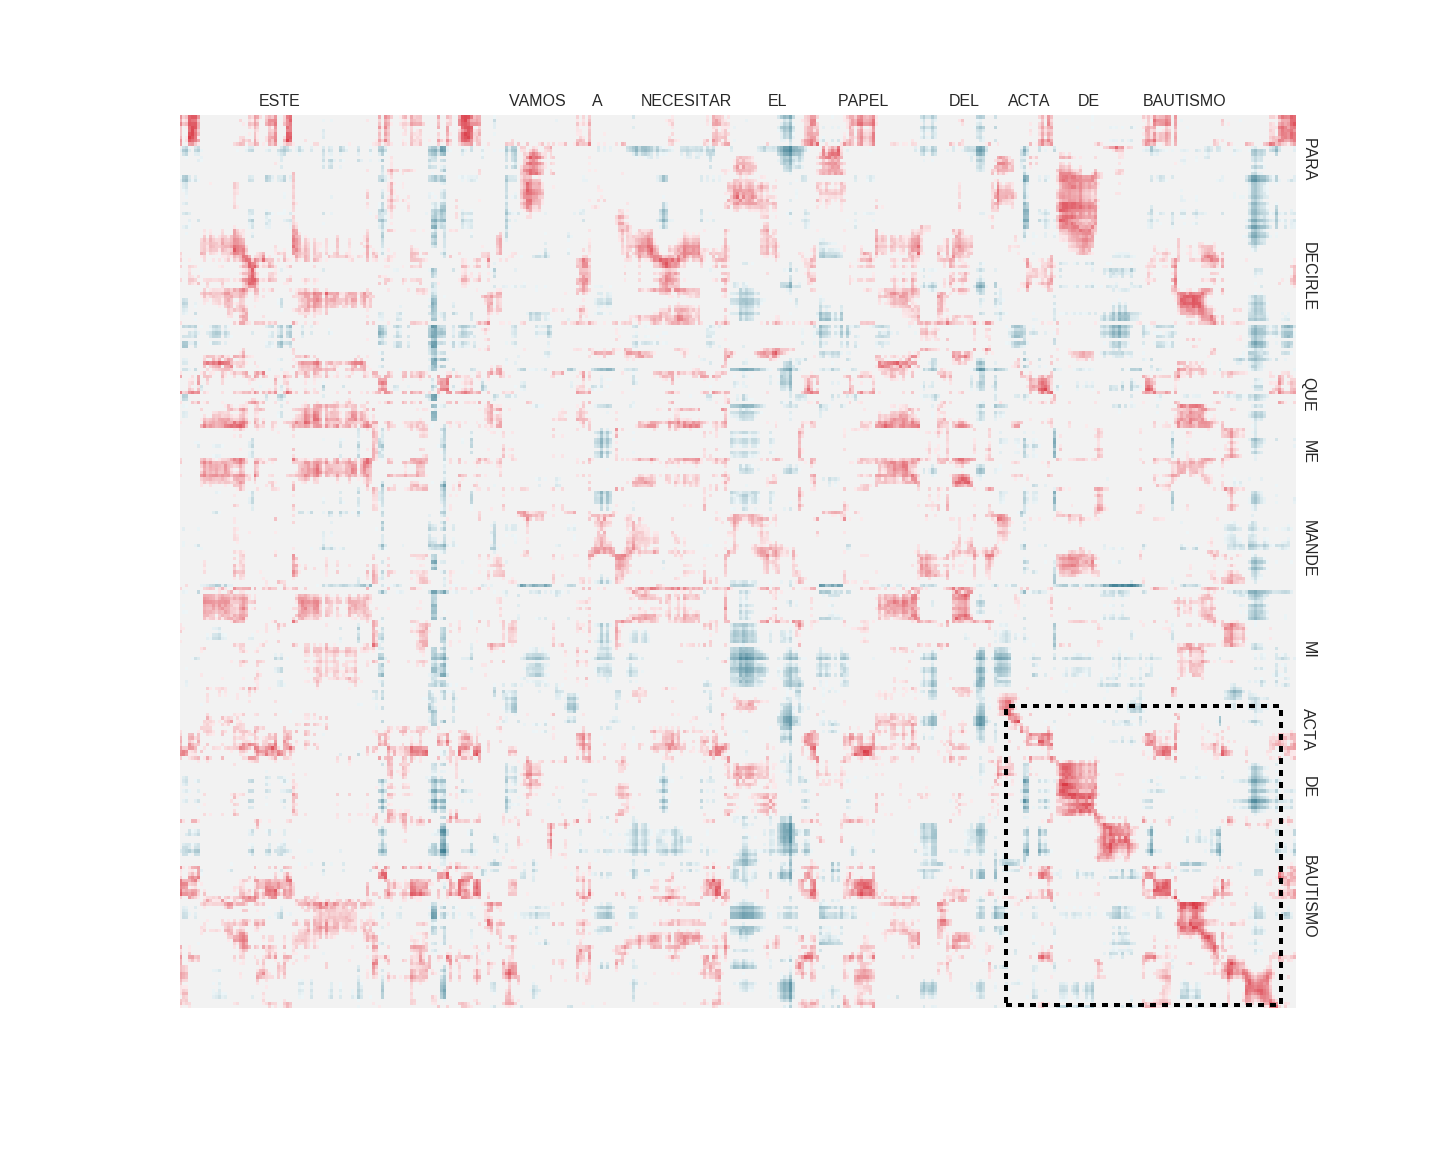

In [6]:
Image("output/dtw_pair_1761_1762.png")

Any diagonal line patterns in an acoustic dotplot signify a common acoustic segment. In this case, we know from the transcripts, that the words are "ACTA DE BAUTISMO". The Zero Resource Toolkit, employs image detection techniques to extract these acoustic segment matches and outputs them as pairs. 

### UTD output

The discovered speech patterns are provided along with the following information:
- Pair id
- Node id for speech segment 1, audio file, start and end times
- Node id for speech segment 2, audio file, start and end times
- A DTW score between 0 and 1.0. A high score indicates a stronger acoustic match

The following tables provide an excerpt of this information:


| Pair id | Node 1 | Node 2 | DTW score | ES content match |
|:-------:|:------:|:------:|:---------:|:----------------:|
|    0    |   1    |   2    |   0.882   |           0           |
|    1    |   2    |   64   |   0.903   |           0           |
|    2    |   3    |   4    |   0.872   |           0           |
|...|...|...|...|...|
|    26   |   27   |   28   |    0.86   |           1           |
|    50   |   61   |   62   |   0.88   |           1           |
|...|...|...|...|...|
|**5119**|**1761**|**1762**|**0.933**| 1 |
|...|...|...|...|...|


| Node id | Speech file | Start time(ms) | End time(ms) |
|:-------:|:-----------:|:-------------:|:-------------:|
|    1    | 049.003.wav |      356       |     411      |
|    2    | 049.007.wav |      371       |     434      |
|    3    | 049.003.wav |       53       |     105      |
|    4    | 049.007.wav |      758       |     811      |
|    27   | 049.003.wav |      572       |     623      |
|    28   | 060.030.wav |      226       |     277      |
|    61   | 049.007.wav |      144       |     201      |
|    62   | 049.073.wav |       20       |      75      |
|    64   | 049.073.wav |      263       |     321      |
|...|...|...|...|
|   1761  | 049.142.wav |      177       |     267      |
|   1762  | 049.152.wav |      279       |     372      |
|...|...|...|...|




### Experimental setup

We use CALLHOME Spanish corpus, which consists of speech from telephone conversations between native speakers. Using the SPRACHcore (#insert_ref#) software package, we generate 39-dimensional Relative Spectral Transform - Perceptual Linear Prediction (PLP) feature vectors. Each dimension is further mean and variance normalised.

For UTD experiment, we use speech from 20 telephone calls. We use a forced alignment of the speech input with transcriptions to generate a gold standard and also for determining the voice active regions. For all experiments, we assume that ground truth voice activity information is available. (#insert how to explain gold standard alignments#). To improve the output of the UTD system, we use the English translations provided as part of (#insert_ref#).

UTD systems are sensitive to silent and background speech regions .To eliminate these regions from the discovery process, we use the following two methods for Voice Activity Detection (VAD):
1. VAD information extracted from forced alignment with transcriptions
This has the advantage of retaining most of the active speech regions in the data. However, due to imperfect alignments, and stop words, some silent regions are left unfiltered. This leads to several spurious pairs being discovered by the Zero Resource Toolkit.

2. VAD information extracted using an energy detection script
The script performs aggressive filtering and removes a lot of voice activity regions in addition to silence and background noise. The VAD regions however lead to better pairs in the ZRT output.

| Type of active speech filtering | Duration of retained speech (hours) |
| -----------------------------: |:---------------------------:|
| Human labeled transcriptions | 3.34  |
| VAD using force alignment with transcriptions | 2.70 |
| VAD using energy detection | 0.91  |


### UTD output evaluation

We use the Spanish transcriptions to evaluate the UTD output. For each pair of segments which the ZRT outputs as an acoustic match, we retrieve the corresponding words from the transcripts. The retrieved words are then filtered for stop words. A discovered pair is assigned a score of 1, if the two segments have atleast one content word in common, otherwise, the score assigned is 0.


| Node id |        ES words        |    ES content words    |
|:-------:|:----------------------:|:----------------------:|
|    1    |    LíNEAS Y ESTABA     |         LíNEAS         |
|    2    |       QUE ESTáN        |          ---           |
|    3    |   MIRA ES QUE ESTOY    |          MIRA          |
|    4    | PUEDE DECIR SEXPERCIOS | PUEDE DECIR SEXPERCIOS |
|    27   |     TRABAJO TENGO      |        TRABAJO         |
|    28   |   TRABAJO QUE TENGA    |        TRABAJO         |
|    61   |       UNA COSA         |         COSA           |
|    62   |  OTRA COSA IMPORTANTE  |    COSA IMPORTANTE     |
|    64   |        EH  A LO        |          EH            |
|   1761  |   ACTA DE BAUTISMO     |     ACTA BAUTISMO      |
|   1762  |   ACTA DE BAUTISMO     |     ACTA BAUTISMO      |






#### Precision/Recall:

After scoring all the discovered pairs using the transcriptions, we calculate the Precision and Recall over the good pairs (with transcription score of 1) at various DTW score thresholds. As per the ZRT documentation, it is recommended to use pairs with a DTW score of 0.88 and a minimum duration of 500 ms.

#### Average Precision:

We also compute an Average Precision metric over the entire range of DTW scores computed over the speech data.

## Improving UTD using English translations

In this work, we attempt to quantify improvements in the UTD output, by utilising additional information in the form of English translations for parts of the speech data. We thus focus on the Low Resource Language setting, as compared to the Zero Resource setting covered in prior work. 

The English translation for an audio file will not follow the ordering of word units as compared to the Spanish transcription. For a given pair of speech utterances, we claim that the similarity in their English translations provides a measure of the expected similarity in the discovered acoustic units. Depending upon the downstream application, only focusing on acoustic similarity to extract word units may not always help.



### Filtering inaccurate discovered pairs

As the ZRToolkit compares speech segments using acoustic information only, this results in phonetically similar, but semantically different utterances being discovered as a pair. Consider the pair id: 15944. The ZRToolkit outputs the following two nodes with a high DTW score. The English translations for these segments, have very little in common. For applications such as Machine Translation, clustering semantically different word units together leads to translation errors. It should be possible to utilize the the lack of similarity between the English translations to rescore this pair.

| node id |    ES transcript     |          EN translation          |
|:-------:|:--------------------:|:--------------------------------:|
|  33935  | ENTONCES YA NO PUEDE | not now now then he cant anymore |
|  33936  |      BUENO PUES      |   yes well its good well yeah    |

Similarity metrics

|            Similarity Type             | Similarity Value |
|:--------------------------------------:|:----------------:|
|                  ZRT                   |      0.881       |
|         ES content word match         |        0         |
|       ES phoneme Edit Similarity       |      0.600       |
|         EN content word match         |        0         |
| EN content words Hellinger Similarity |      0.000       |


We use two similariy metrics over the words in the English translations:
1. 0 if the translations have no content words in common, 1 otherwise
2. Hellinger Similarity, calculated by assigning a probability distribution over each English word in a translation, based on it's frequency of occurrence



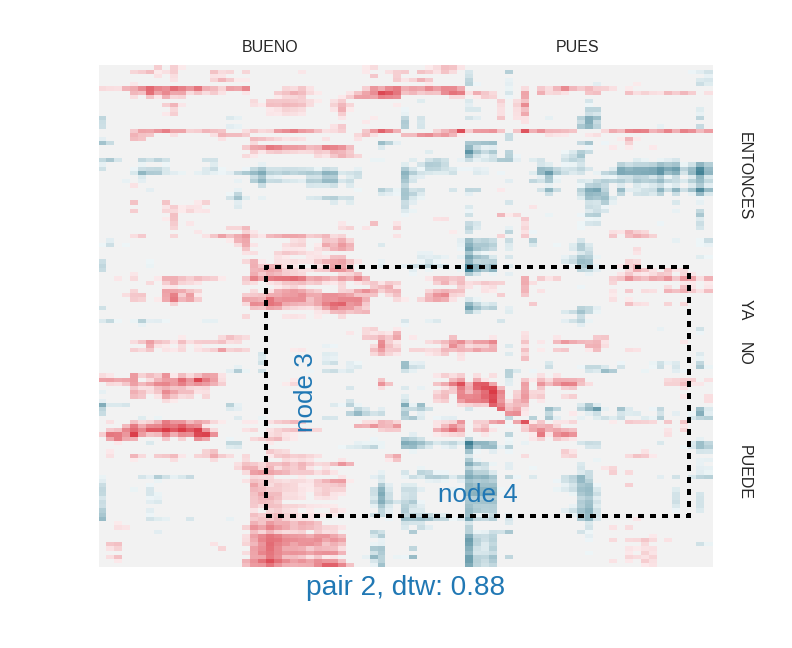

In [7]:
Image("output/15944.png")

### Good pairs being scored as marginal by ZRT

There are also pairs in the output, where the ZRToolkit assigns a fair score to the matched speech segments, and the transcriptions confirm that they are a good match. It is reasonable to expect that the English translations for such segments would also be similar. Consider the pair id 16848. The assigned DTW score for this pair is below the recommended threshold for selecting ZRT output. However, the English translations for the segments are quite similar.


| node id | ES transcript  |                 EN translation                 |
|:-------:|:--------------:|:----------------------------------------------:|
|  44099  | MIL DOSCIENTOS | okay this the address two thousand two hundred |
|  44100  | MIL DOSCIENTOS |            two thousand two hundred            |


Similarity metrics

|            Similarity Type             | Similarity Value |
|:--------------------------------------:|:----------------:|
|                  ZRT                   |      0.864       |
|         ES content word match         |        1         |
|       ES phoneme Edit Similarity       |      1.000       |
|         EN content word match         |        1         |
| EN content words Hellinger Similarity |      0.377       |

In this example, the similarity between English translations can be used to push up the DTW score.

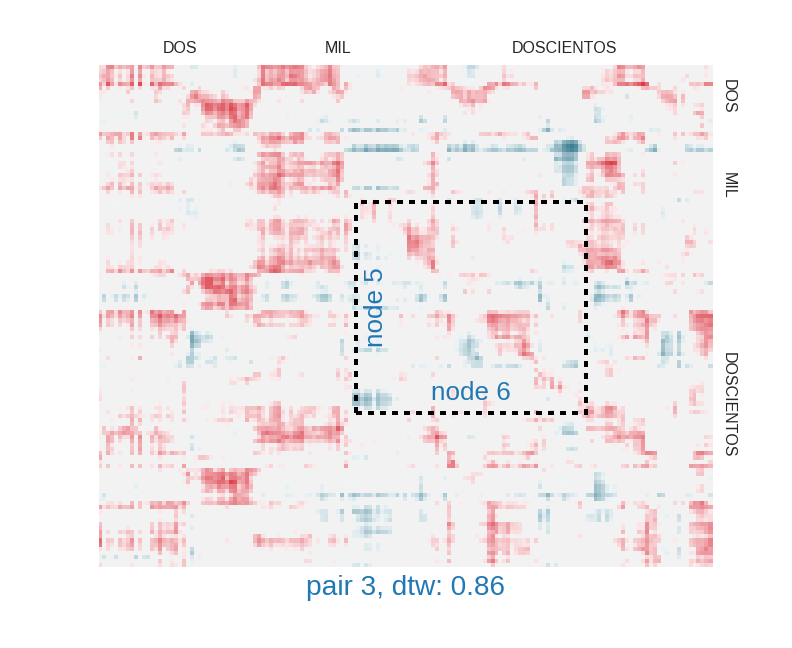

In [8]:
Image("output/16848.png")

## Experiments

Our goal is to quantitavely evaluate the discovered speech pairs. For an intrinsic evaluation, we use the force aligned transcriptions to compute an Average Precision over UTD output. To test extrinsically, we generate a UTD to English translation model and compute precision and recall metrics.

We also attempt to quantify the improvements in UTD output, which can be achieved using additional information, which in this case is English translations. The translations can be considered as a form of noisy label.

### UTD output

| Configuration | Total pairs discovered | Avg. Precision - Audio only | Avg. Precision - using translations
|----:|:----:|:----:|:----:|
| 20 speech files, alignment based VAD | 10452 | 0.268 | 0.474

Distribution of DTW scores. Minimum pair duration of 500ms.

Takeaway - Several spurious discovered pairs

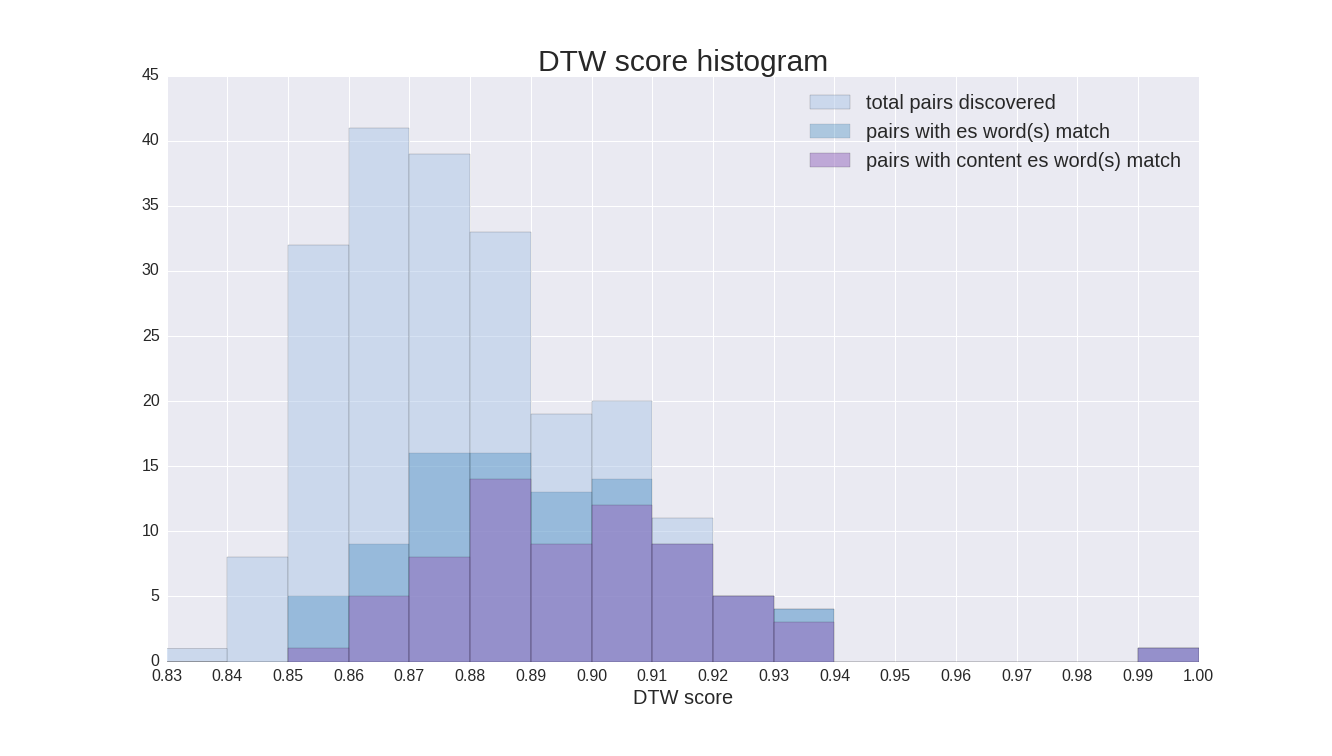

In [9]:
Image('output/train_20_transcrpt_vad_hist.png')

Distribution of DTW scores with energy detection based VAD regions. Minimum pair duration of 500ms.

Takeaway - Better accuracy of discovered pairs at high DTW thresholds. However, very few pairs discovered. High precision, low recall.

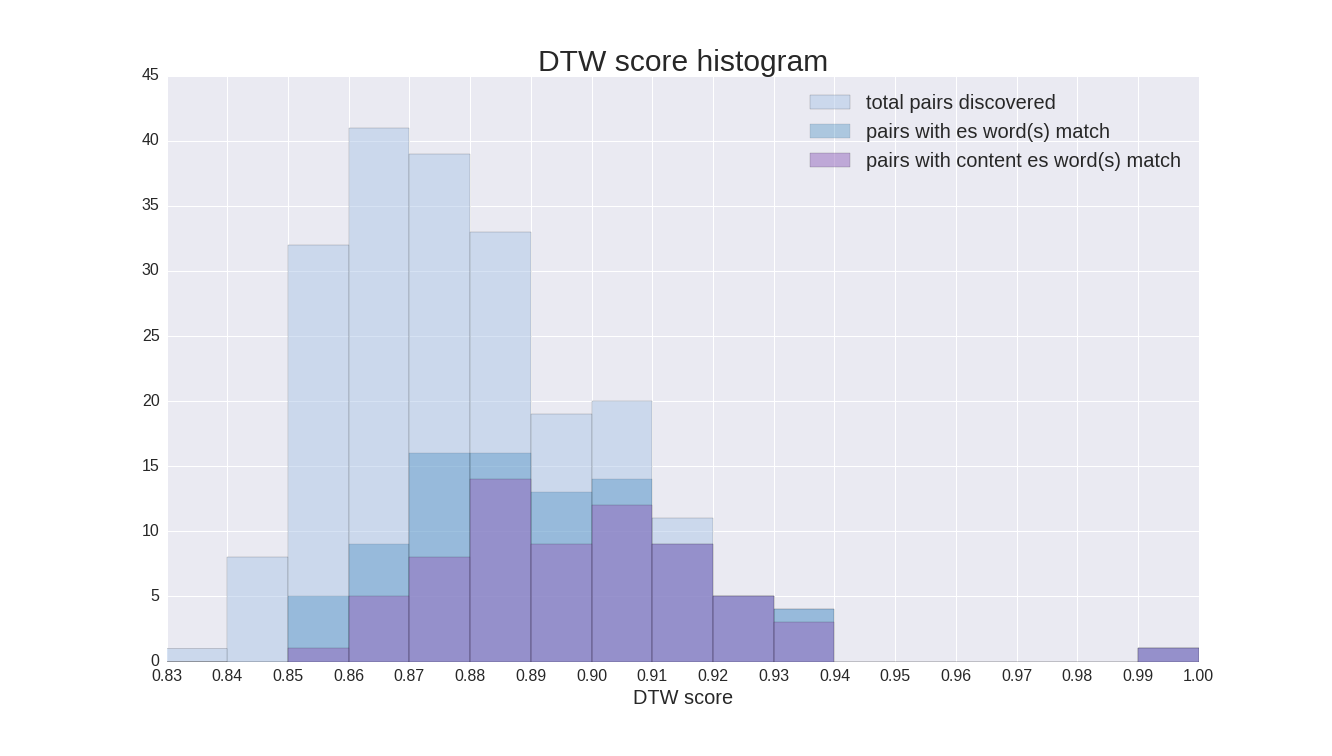

In [10]:
Image('output/train_20_energy_vad_hist.png')

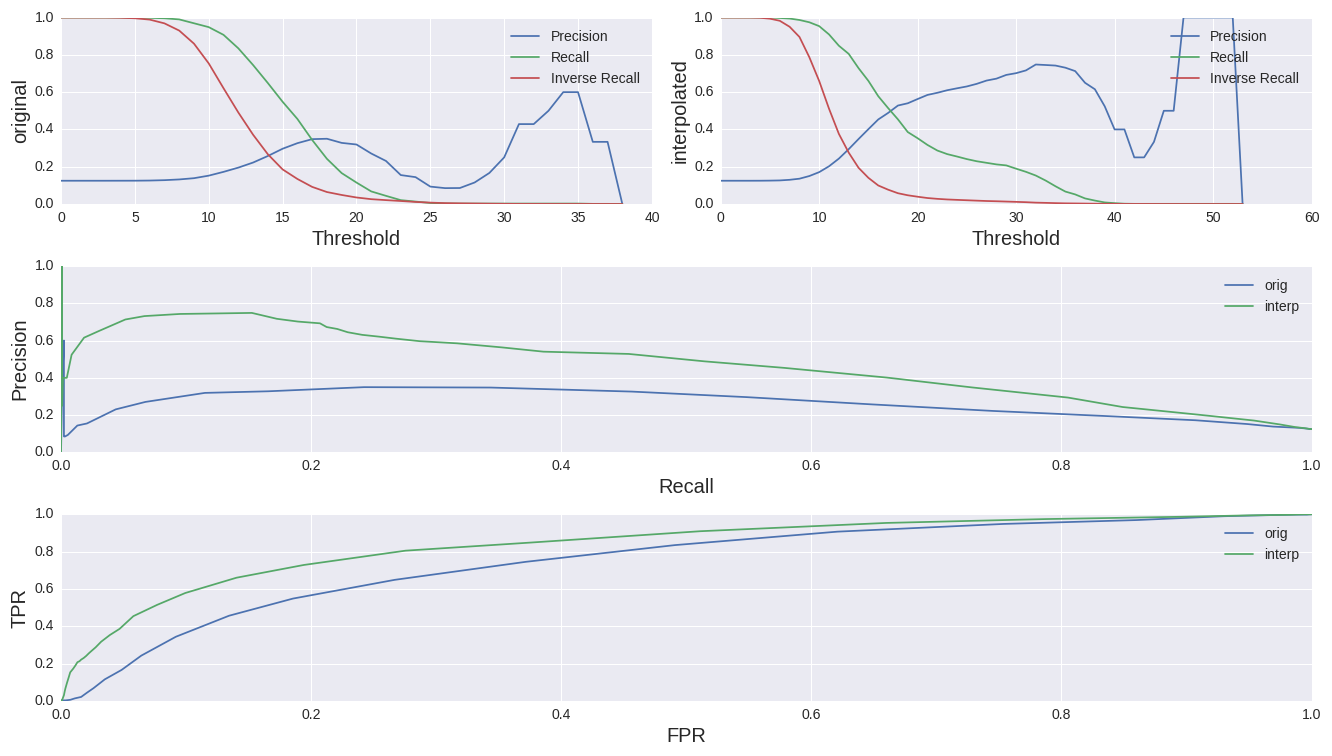

In [11]:
Image("output/train_20_avg_precision.png")

### Cross-Speaker matches

For 20 telephone conversations, we have 40 speakers, a minimum of 2 per call. However, the data does have certain speakers repeat calls.

The number of cross-speaker pairs discovered is: 6512

Takeaway - The sparsity in the plots shows that cross speaker variation is a challenge.

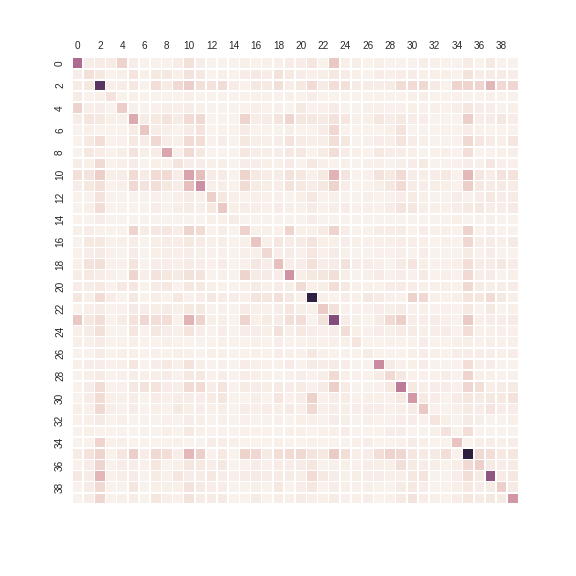

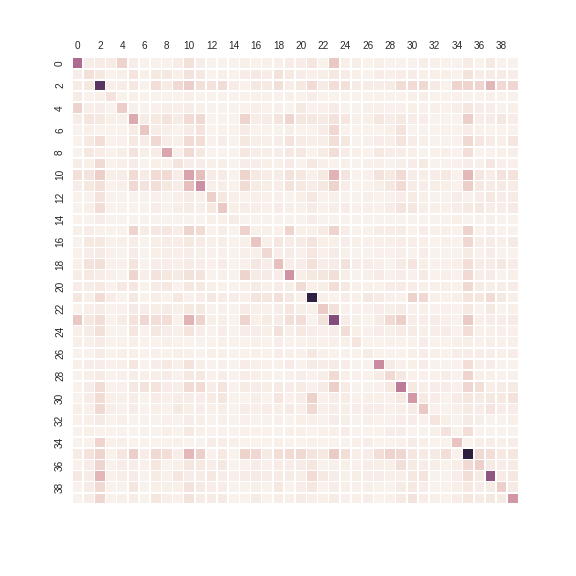

In [12]:
display(Image("output/train_20_cross_spkrs.png"))
display(Image("output/train_20_only_cross_spkrs.png"))

### UTD experiments configurations/parameters

| Configuration | DTW score        | Overlap threshold | Duration (ms) |  
| ------------- |:-------------:|
| 20 telephone calls | 0.80     | 0.90 | 500 |
| 20 telephone calls (energy script) | 0.80     | 0.90 | 500 |
| 50 telephone calls | 0.80     | 0.90 | 500 |
| 50 telephone calls (energy script)| 0.80     | 0.90 | 500 |



Results:

Good examples:
callhome_20:
display_pair_and_plot_dtw(5118, tosave=False)
display_pair_and_plot_dtw(15944, tosave=True)
display_pair_and_plot_dtw(16848, tosave=True)
display_pair_and_plot_dtw(19326, tosave=False)

Good links:

- http://stackoverflow.com/questions/33680633/how-to-change-pyplot-specgram-x-and-y-axis-scaling

